In [2]:
import json

def compare_json_answers(original_file, model_file):
    """
    Compares answer keys in two JSON files based on matching IDs.

    Args:
        original_file (str): Path to the JSON file with correct answers.
        model_file (str): Path to the JSON file with model output answers.

    Returns:
        tuple: A tuple containing:
            - total_items (int): Total number of items in the original file.
            - correct_count (int): Number of items where ID and answer_key match.
            - percentage (float): Percentage of correct answers (correct_count / total_items * 100).
            Returns (0, 0, 0.0) if the original file is empty or cannot be processed.
        None: If there's an error reading or parsing the files.
    """
    try:
        # --- Load Original Answers ---
        with open(original_file, 'r', encoding='utf-8') as f:
            original_data = json.load(f)

        # --- Load Model Output ---
        with open(model_file, 'r', encoding='utf-8') as f:
            model_data = json.load(f)

    except FileNotFoundError as e:
        print(f"Error: File not found - {e}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error: Could not decode JSON in file - {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred during file reading: {e}")
        return None

    # --- Prepare Model Answers for Quick Lookup ---
    # Create a dictionary {id: answer_key} from the model output
    model_answers_map = {}
    for item in model_data:
        if 'id' in item and 'answer_key' in item:
             # Handle potential duplicate IDs in model output: last one wins
            model_answers_map[item['id']] = item['answer_key']
        else:
            print(f"Warning: Skipping item in {model_file} due to missing 'id' or 'answer_key': {item}")


    # --- Compare and Count ---
    correct_count = 0
    total_items = 0

    if not original_data:
        print(f"Warning: The original answer file '{original_file}' is empty or contains no valid data.")
        return 0, 0, 0.0

    for original_item in original_data:
        if 'id' not in original_item or 'answer_key' not in original_item:
            print(f"Warning: Skipping item in {original_file} due to missing 'id' or 'answer_key': {original_item}")
            continue # Skip this item if essential keys are missing

        total_items += 1
        item_id = original_item['id']
        correct_answer = original_item['answer_key']

        # Check if the model provided an answer for this ID
        if item_id in model_answers_map:
            model_answer = model_answers_map[item_id]
            # Compare the answers (case-sensitive by default)
            if model_answer == correct_answer:
                correct_count += 1
            # Optional: Uncomment to see mismatches
            # else:
            #    print(f"Mismatch for ID {item_id}: Expected '{correct_answer}', Got '{model_answer}'")
        else:
            print(f"Warning: ID '{item_id}' from {original_file} not found in {model_file}.")
            # This item is counted in total_items but not in correct_count

    # --- Calculate Percentage ---
    if total_items > 0:
        percentage = (correct_count / total_items) * 100.0
    else:
        percentage = 0.0 # Avoid division by zero if original file was effectively empty

    return total_items, correct_count, percentage

# --- Main Execution ---
if __name__ == "__main__":
    original_filename = "/content/original_answer.json"
    model_filename = "/content/model_output.json"

    result = compare_json_answers(original_filename, model_filename)

    if result is not None:
        total, correct, percent = result
        print("\n--- Comparison Results ---")
        print(f"Total items compared (based on '{original_filename}'): {total}")
        print(f"Correctly matched answers: {correct}")
        if total > 0:
            print(f"Accuracy Percentage: {percent:.2f}%")
        else:
            print("Accuracy Percentage: N/A (no items to compare)")


--- Comparison Results ---
Total items compared (based on '/content/original_answer.json'): 4797
Correctly matched answers: 2250
Accuracy Percentage: 46.90%


In [3]:
pip install matplotlib

Running example plot generation...

Example Data:
  Total: 4797
  Correct: 2250
  Incorrect: 1000
  Missing: 1547
  Percentage: 46.90%
Generating Accuracy Percentage plot...


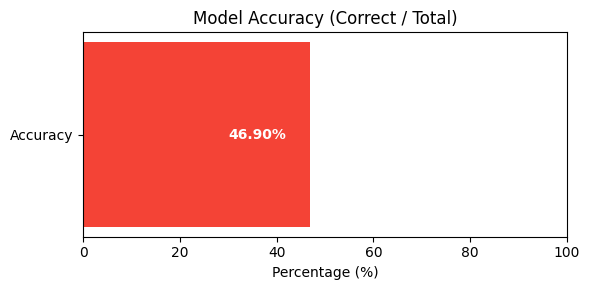

Generating Answer Breakdown plot...


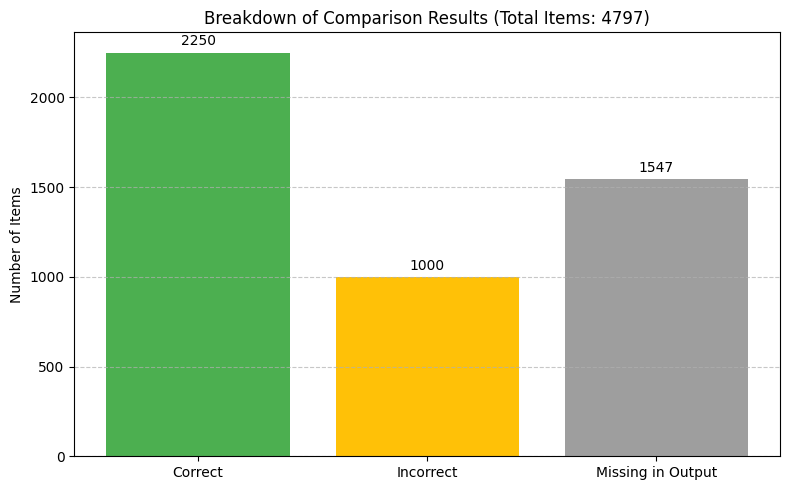


Example plotting complete.


In [5]:
import matplotlib.pyplot as plt

def plot_comparison_results(total, correct, incorrect, missing, percentage):
    """
    Generates plots based on the comparison results.

    Args:
        total (int): Total items compared (from the original/reference file).
        correct (int): Number of correctly matched answers.
        incorrect (int): Number of items where ID matched but answer_key didn't.
        missing (int): Number of items from original file missing in model output.
        percentage (float): Overall accuracy percentage (correct / total * 100).
    """

    if total == 0:
        print("\nNo data to plot (Total items is zero).")
        return

    # --- Plot 1: Overall Accuracy Percentage ---
    print("Generating Accuracy Percentage plot...")
    plt.figure(figsize=(6, 3)) # Adjust figure size
    bars = plt.barh(['Accuracy'], [percentage], color=['#4CAF50' if percentage >= 50 else '#F44336']) # Green if >= 50%, else Red
    plt.xlim(0, 100)
    plt.xlabel("Percentage (%)")
    plt.title("Model Accuracy (Correct / Total)")
    # Add percentage text on the bar
    for bar in bars:
        # Adjust text position and color for better visibility
        text_x_pos = bar.get_width() - 5 if bar.get_width() > 15 else bar.get_width() + 1
        ha_align = 'right' if bar.get_width() > 15 else 'left'
        text_color = 'white' if bar.get_width() > 15 else 'black'

        plt.text(text_x_pos,
                 bar.get_y() + bar.get_height()/2,
                 f'{percentage:.2f}%',
                 va='center', ha=ha_align, color=text_color, fontweight='bold')
    plt.tight_layout() # Adjust layout
    plt.show() # Display the plot

    # --- Plot 2: Answer Breakdown ---
    print("Generating Answer Breakdown plot...")
    labels = ['Correct', 'Incorrect', 'Missing in Output']
    counts = [correct, incorrect, missing]
    # Ensure counts don't contain None or non-numeric values if passed incorrectly
    counts = [int(c) if c is not None else 0 for c in counts]
    colors = ['#4CAF50', '#FFC107', '#9E9E9E'] # Green, Amber, Grey

    # Filter out categories with zero count for cleaner plotting if desired
    # labels = [l for i, l in enumerate(labels) if counts[i] > 0]
    # colors = [c for i, c in enumerate(colors) if counts[i] > 0]
    # counts = [c for c in counts if c > 0]
    # if not counts: # Don't plot if all counts became zero after filtering
    #      print("No non-zero counts to plot in breakdown.")
    #      return

    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels, counts, color=colors)
    plt.ylabel("Number of Items")
    plt.title(f"Breakdown of Comparison Results (Total Items: {total})")
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Add horizontal grid lines

    # Add count numbers on top of bars
    max_count = max(counts) if counts else 1 # Avoid division by zero if counts is empty
    for bar in bars:
        yval = bar.get_height()
        # Place text slightly above the bar
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + max_count*0.01, int(yval), va='bottom', ha='center')

    # Optional: Add total items text inside the plot area if needed
    # plt.text(len(labels)-0.5, max(counts)*0.95, f'Total Items: {total}', ha='right', style='italic',
    #          bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

    plt.tight_layout()
    plt.show() # Display the plot


# --- Example Usage ---
if __name__ == "__main__":
    print("Running example plot generation...")

    # Example data (replace with your actual calculated values)
    example_total = 4797
    example_correct = 2250
    example_incorrect = 1000 # Made up number for illustration
    example_missing = example_total - example_correct - example_incorrect # Calculate missing based on others
    example_percentage = (example_correct / example_total) * 100 if example_total > 0 else 0

    print(f"\nExample Data:")
    print(f"  Total: {example_total}")
    print(f"  Correct: {example_correct}")
    print(f"  Incorrect: {example_incorrect}")
    print(f"  Missing: {example_missing}")
    print(f"  Percentage: {example_percentage:.2f}%")

    # Call the plotting function with example data
    plot_comparison_results(
        total=example_total,
        correct=example_correct,
        incorrect=example_incorrect,
        missing=example_missing,
        percentage=example_percentage
    )

    print("\nExample plotting complete.")

    # --- Example with Zero Total ---
    # print("\nRunning example with zero total...")
    # plot_comparison_results(0, 0, 0, 0, 0.0)